In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [7]:
df = load_pkl('../../data/feat_engin/lgbm/data_1hour_1day.pkl')

In [10]:
df.shape

(1013212, 610)

In [12]:
# VEON-RX
df = df[df['ticker'] != 'VEON-RX']
df.shape

(1007027, 610)

In [15]:
df.head()

,time,close,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,...,tmos_close_1day_w100_ma_up_3std/tmos_close_1day,close_1day_w3_min/close_1day_w3_max,volume_1day_w3_min/volume_1day_w3_max,tmos_close_1day_w3_min/tmos_close_1day_w3_max,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max
0,2022-05-05 10:00:00,31.24,AFLT,0.0,LOSE,1 days 00:00:00,0.98,30.379999,18,0.001282,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2022-05-05 11:00:00,30.98,AFLT,0.0,LOSE,1 days 01:00:00,0.98,30.280001,20,-0.008323,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-05-05 12:00:00,30.92,AFLT,0.0,LOSE,1 days 00:00:00,0.98,30.280001,20,-0.001937,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2022-05-05 13:00:00,30.92,AFLT,0.0,LOSE,0 days 23:00:00,0.98,30.280001,20,0.000000,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2022-05-05 14:00:00,31.00,AFLT,0.0,LOSE,0 days 22:00:00,0.98,30.280001,20,0.002587,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
df['result'].value_counts(normalize=True)

result
DNF     0.472023
LOSE    0.361183
WIN     0.166794
Name: proportion, dtype: float64

In [19]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.980000
0.01    0.980000
0.10    0.980000
0.20    0.980000
0.30    0.980000
0.40    0.988029
0.50    0.996794
0.60    1.003744
0.70    1.012255
0.80    1.026473
0.90    1.040000
0.99    1.040000
1.00    1.040000
Name: income_rate, dtype: float64

## CHANGE TARGET

In [23]:
def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: #short game
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            if val_first < val_second:
                income_rate = res_price/start_price
            else: #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            if val_first < val_second:
                income_rate = res_price/start_price
            else:  #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })
    return df_result    

In [25]:
df_result = load_pkl('../../data/feat_engin/lgbm/df_result_wait_14_2days.pkl')
df_result = df_result[['time', 'close', 'ticker']]
df_result

,time,close,ticker
0,2022-05-04 10:00:00,32.100,AFLT
1,2022-05-04 11:00:00,31.380,AFLT
2,2022-05-04 12:00:00,31.800,AFLT
3,2022-05-04 13:00:00,31.360,AFLT
4,2022-05-04 14:00:00,31.540,AFLT
...,...,...,...
1014345,2025-02-04 19:00:00,11.095,RBCM
1014346,2025-02-04 20:00:00,11.090,RBCM
1014347,2025-02-04 21:00:00,11.105,RBCM
1014348,2025-02-04 22:00:00,11.070,RBCM


In [27]:
inds = np.arange(df_result.shape[0])
inds.shape

(1014350,)

In [29]:
df_result = get_df_target(df_result, inds, percent_first=1.005, percent_second=0.99, points_to_wait=14*1)
df_result["income_rate"] = np.maximum(df_result["income_rate"], 0.995)
df_result["income_rate"] = np.minimum(df_result["income_rate"], 1.01)


100%|█████████████████████████████████████████████████████████████| 1014350/1014350 [04:05<00:00, 4135.57it/s]


In [30]:
df_result['result'].value_counts(normalize=True)

result
LOSE    0.541439
WIN     0.346656
DNF     0.111904
Name: proportion, dtype: float64

In [31]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.995000
0.01    0.995000
0.10    0.995000
0.20    0.995000
0.30    0.995000
0.40    0.995000
0.50    0.995000
0.60    1.002533
0.70    1.010000
0.80    1.010000
0.90    1.010000
0.99    1.010000
1.00    1.010000
Name: income_rate, dtype: float64

In [32]:
(df_result['ind'] == df_result.index).all()

True

In [34]:
df_result = df_result[['time','result', 'ticker', 'delta_time', 'income_rate',
       'res_price', 'res_ind']]

In [36]:
df.shape

(1007027, 610)

In [38]:
#join
df = df[df.columns[~df.columns.isin(['result', 'delta_time', 'income_rate', 'res_price', 'res_ind'])]].merge(
    df_result, how='inner', on=['time', 'ticker'])
df.shape

(1007027, 610)

### 1. train/valid/test/test2 split

In [42]:
df["income_rate"] -= 0.001

In [43]:
df['target'] = (df['result'] == 'WIN').astype(int)

<Axes: xlabel='time'>

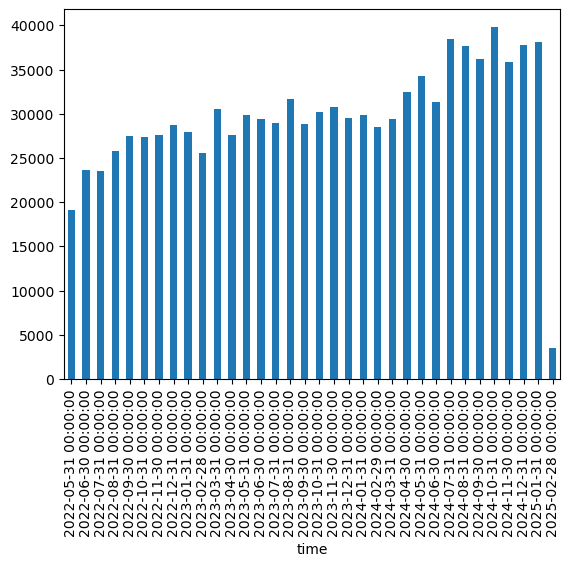

In [44]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.count().plot.bar()

<Axes: xlabel='time'>

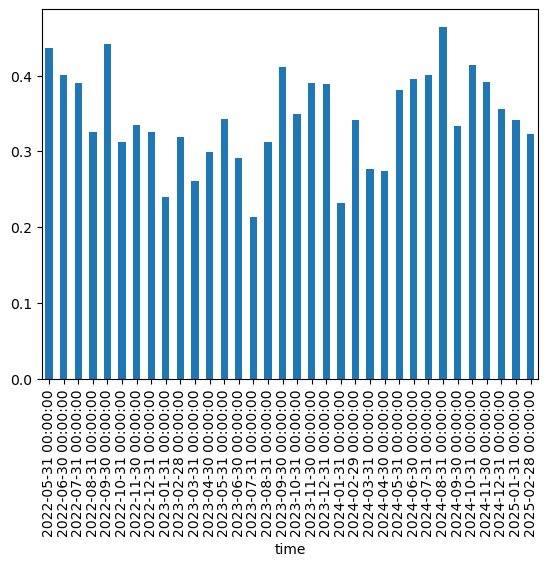

In [45]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

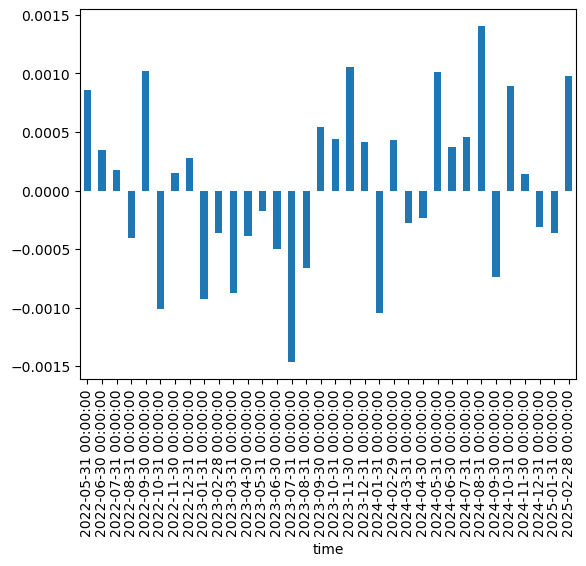

In [46]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [48]:
pd.set_option('display.max_rows', 150)
df[['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
LKOH     0.234031
SBERP    0.236044
AKRN     0.237169
SBER     0.241942
IRAO     0.242568
PHOR     0.246656
TATNP    0.248999
TATN     0.258717
TRNFP    0.259318
MTSS     0.267987
MOEX     0.269567
SNGSP    0.271119
GAZP     0.276860
RTKM     0.282629
ROSN     0.286436
CBOM     0.288392
HYDR     0.297913
RTKMP    0.299145
SIBN     0.302750
BELU     0.304010
ALRS     0.305199
PLZL     0.305260
MSRS     0.307854
GMKN     0.308744
POSI     0.309717
CHMF     0.312849
LSNGP    0.316618
NVTK     0.318234
MSNG     0.319294
VTBR     0.319902
MAGN     0.322879
AFLT     0.322941
MGNT     0.322985
YDEX     0.323413
RUAL     0.325187
OGKB     0.325323
PMSB     0.326525
NLMK     0.326879
MRKC     0.329063
MRKP     0.329063
BSPB     0.330862
UPRO     0.330889
BANE     0.331427
SNGS     0.331577
BANEP    0.332181
AFKS     0.333614
GCHE     0.335344
T        0.335375
AQUA     0.335503
PIKK     0.336528
MDMG     0.338498
KRKNP    0.339679
NKNCP    0.339930
KAZT     0.340561
FEES     0.345555
FLO

In [49]:
df[['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
IRAO     0.999289
AKRN     0.999309
TATN     0.999360
MSRS     0.999396
SBERP    0.999399
SBER     0.999403
TATNP    0.999423
MOEX     0.999445
MRKC     0.999459
BANE     0.999473
SNGSP    0.999509
PMSB     0.999513
LKOH     0.999523
PLZL     0.999563
CHMF     0.999565
CBOM     0.999577
MRKP     0.999582
ROSN     0.999584
PHOR     0.999617
POSI     0.999634
MTSS     0.999658
GCHE     0.999661
LSNGP    0.999666
MSNG     0.999691
YDEX     0.999696
MDMG     0.999700
BANEP    0.999711
ALRS     0.999715
NLMK     0.999721
SIBN     0.999745
PMSBP    0.999760
AFKS     0.999790
RTKM     0.999805
RENI     0.999807
RTKMP    0.999811
SNGS     0.999814
NKNCP    0.999821
BSPB     0.999823
BELU     0.999824
AFLT     0.999831
TRNFP    0.999868
TTLK     0.999872
OGKB     0.999882
SFIN     0.999889
KAZT     0.999903
MAGN     0.999925
KRKNP    0.999955
NVTK     0.999967
GMKN     0.999973
MVID     0.999974
LSRG     0.999980
MRKV     0.999992
T        0.999994
PIKK     0.999995
MGNT     0.999997
FEE

In [50]:
df['time'].max()

Timestamp('2025-02-04 23:00:00')

In [51]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-12-23')))
mask_test3 = np.array((pd.Timestamp('2024-12-23') <= df['time']) & (df['time'] < pd.Timestamp('2025-01-28')))

In [52]:
mask_test3.sum()

43169

In [53]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(708395, 69770, 73874, 101413)

In [55]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 101
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all


#мб дату неправильно обрезаю

In [56]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(592135, 69770, 73874, 101413)

In [60]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

837192

In [61]:
df.loc[mask_data].isnull().sum()[df.loc[mask_data].isnull().sum() > 0].sort_values()

Series([], dtype: int64)

In [64]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7072869783753308,
 0.08333811120985389,
 0.08824021251994764,
 0.12113469789486761)

In [66]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.31638055510989893,
 0.3985523864124982,
 0.3997346833798089,
 0.399751511147486)

In [67]:
df.loc[mask_test3, 'target'].mean()

0.33097824828001576

In [68]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(0.9998429740718676,
 1.0004175647012303,
 1.0003553860687855,
 1.0004302697069642)

In [70]:
df.loc[mask_test3, 'income_rate'].mean()

0.9994235042765756

In [73]:
#проверки

In [74]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

### 3.1 Base model

In [78]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

In [79]:
df['ticker_code'].nunique()

126

In [80]:
df.loc[mask_train, 'ticker_code'].nunique()

126

In [81]:
df.columns.tolist()

['time',
 'close',
 'ticker',
 'index_1day',
 'close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.005',
 'close_w70_lvl_-0.995-1',
 'close_w70_lvl_1.005-1.01',
 'close_w70_lvl_-0.99-0.995',

In [82]:
drop_cols = ['time',
             #'ticker_code',
             #'hour', 'day', 'weekday', 

 'ticker',
 'index_1day',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind', 'index', 'target', 
              'ind', 'close',
             'y_pred'] #+ [elem for elem in df.columns if 'roc' in elem]


features = df.columns[~df.columns.isin(drop_cols)].tolist()
#features = [elem for elem in df.columns if (('/' in elem) or ('lvl' in elem) or ('alpha' in elem))] +['hour', 'day', 'weekday'] + #['ticker_code']
                                                                                                    


cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',# 'month'
]
cat_features = cat_features_all

target = 'target'

In [83]:
len(features)

601

### Get stability features

In [3013]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 2,

     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     "verbose": 0,
    "metric": "auc",
    "early_stopping" : 20, 
}

auc_features = {'feature' : [],
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : []
               }

for feature in tqdm(features):
    stab_features = [feature]
    stab_cat_features = [feature] if feature in cat_features else []
    
    D_train = lgbm.Dataset(df.loc[mask_train, stab_features], label=df.loc[mask_train, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
        
    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid])
    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)

    auc_features['feature'] += [feature]
    auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

auc_features_cp = auc_features.copy()

100%|███████████████████████████████████████████████████████████████████████| 601/601 [03:09<00:00,  3.18it/s]


In [3015]:
df_auc_features = pd.DataFrame(auc_features)
df_auc_features

,feature,auc_train,auc_valid,auc_test,auc_test2
0,close_w1_roc,0.540673,0.521399,0.529992,0.528176
1,volume_w1_roc,0.514040,0.515459,0.508169,0.508426
2,tmos_close_w1_roc,0.518604,0.528220,0.517684,0.513818
3,close_w5_norm_std,0.576741,0.520632,0.518216,0.511367
4,close_w5_mean_abs_pct,0.587664,0.519093,0.518260,0.510422
...,...,...,...,...,...
596,tmos_close_1day_w5_min/tmos_close_1day_w5_max,0.524649,0.500000,0.500000,0.500000
597,close_1day_w20_min/close_1day_w20_max,0.558248,0.495419,0.494614,0.510727
598,volume_1day_w20_min/volume_1day_w20_max,0.552764,0.508031,0.510756,0.504380
599,tmos_close_1day_w20_min/tmos_close_1day_w20_max,0.515875,0.500161,0.500000,0.506427


#### auc <=0.525

In [3018]:
auc_treshold = 0.51

In [3019]:
mask_auc_train  = df_auc_features['auc_train'] <= auc_treshold 
mask_auc_train.sum()

78

In [3020]:
mask_auc_valid  = df_auc_features['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

339

In [3021]:
mask_auc_test  = df_auc_features['auc_test'] <= auc_treshold 
mask_auc_test.sum()

427

In [3022]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

494

In [3024]:
mask_auc_test2  = df_auc_features['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

445

In [3025]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

534

#### delta_auc > 0.05

In [3029]:
auc_delta_treshold  = 0.03

In [3030]:
mask_auc_delta_valid = (df_auc_features['auc_train'] - df_auc_features['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

180

In [3031]:
mask_auc_delta_test = (df_auc_features['auc_train'] - df_auc_features['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

190

In [3032]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

252

In [3034]:
mask_auc_delta_test2 = (df_auc_features['auc_train'] - df_auc_features['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

225

In [3035]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

309

#### union criterias

In [3038]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

540

In [3039]:
mask_criterias2 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2 | mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2
mask_criterias2.sum()

570

In [3041]:
features_criteria1 = df_auc_features['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(61,
 array(['close_w1_roc', 'tmos_close_w1_roc', 'volume_w5_norm_std',
        'volume_w5_mean_abs_pct', 'close_w14_alpha', 'tmos_close_w14_rsi',
        'tmos_close_w14_roc', 'close_w70_rsi', 'close_w70_lvl_-0.98-0.99',
        'tmos_close_w70_alpha', 'tmos_close_w70_rsi', 'tmos_close_w70_roc',
        'tmos_close_w70_lvl_1.005-1.01', 'tmos_close_w70_lvl_1.01-1.015',
        'tmos_close_w70_lvl_-0.985-0.99', 'tmos_close_w70_lvl_1.02-1.03',
        'hour', 'sin_time_hour', 'close_w5_alpha/close_w70_alpha',
        'close_w5_mean_abs_pct/close_w70_mean_abs_pct',
        'volume_w5_std/volume_w14_std',
        'tmos_close_w5_std/tmos_close_w70_std',
        'tmos_close_w5_norm_std/tmos_close_w70_norm_std',
        'tmos_close_w14_rsi/tmos_close_w70_rsi',
        'tmos_close/tmos_close_w70_ma',
        'tmos_close_w5_ma/tmos_close_w70_ma',
        'tmos_close_w14_ma/tmos_close_w70_ma', 'volume_w5_min/volume',
        'tmos_close_w5_max/tmos_close', 'tmos_close_w14_max/tmos_close',
      

In [3042]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2
67,tmos_close_w70_lvl_-0.985-0.99,0.541510,0.570131,0.518499,0.528181
187,tmos_close_w14_max/tmos_close,0.542651,0.566806,0.532106,0.525026
542,tmos_close_1day_w100_max/tmos_close_1day,0.527333,0.556230,0.513946,0.488517
588,tmos_close_1day_w100_ma_up_2std/tmos_close_1day,0.534781,0.555855,0.515171,0.499053
64,tmos_close_w70_lvl_1.005-1.01,0.525084,0.552860,0.549707,0.519750
32,tmos_close_w14_roc,0.526380,0.549637,0.514166,0.518476
186,tmos_close_w5_max/tmos_close,0.539125,0.548944,0.544197,0.511642
70,tmos_close_w70_lvl_1.02-1.03,0.522234,0.548810,0.546560,0.489203
31,tmos_close_w14_rsi,0.520516,0.547832,0.526868,0.528993
250,tmos_close_1day_w3_rsi,0.540450,0.543352,0.529080,0.503274


In [5076]:
features_criteria2 = df_auc_features['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

(31,
 array(['close_w1_roc', 'tmos_close_w1_roc', 'volume_w5_norm_std',
        'volume_w5_mean_abs_pct', 'tmos_close_w14_rsi',
        'tmos_close_w14_roc', 'close_w70_rsi', 'close_w70_lvl_-0.98-0.99',
        'tmos_close_w70_rsi', 'tmos_close_w70_roc',
        'tmos_close_w70_lvl_1.005-1.01', 'tmos_close_w70_lvl_1.01-1.015',
        'tmos_close_w70_lvl_-0.985-0.99', 'hour', 'sin_time_hour',
        'volume_w5_std/volume_w14_std',
        'tmos_close_w5_ma/tmos_close_w70_ma',
        'tmos_close_w14_ma/tmos_close_w70_ma', 'volume_w5_min/volume',
        'tmos_close_w5_max/tmos_close', 'tmos_close_w14_max/tmos_close',
        'tmos_close_w70_ma_up_2std/tmos_close',
        'volume_w5_min/volume_w5_max', 'close_1day_w5_alpha',
        'tmos_close_1day_w20_lvl_1.005-1.01',
        'tmos_close_1day_w20_lvl_1.015-1.02',
        'tmos_close_1day_w100_lvl_1.015-1.02',
        'tmos_close_1day_w100_lvl_1.04-1.05',
        'close_1day_w3_roc/close_1day_w20_roc',
        'tmos_close_1day_w3_mea

In [5078]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2
67,tmos_close_w70_lvl_-0.985-0.99,0.541510,0.570131,0.518499,0.528181
187,tmos_close_w14_max/tmos_close,0.542651,0.566806,0.532106,0.525026
64,tmos_close_w70_lvl_1.005-1.01,0.525084,0.552860,0.549707,0.519750
32,tmos_close_w14_roc,0.526380,0.549637,0.514166,0.518476
186,tmos_close_w5_max/tmos_close,0.539125,0.548944,0.544197,0.511642
31,tmos_close_w14_rsi,0.520516,0.547832,0.526868,0.528993
169,tmos_close_w5_ma/tmos_close_w70_ma,0.534563,0.539132,0.529857,0.524465
66,tmos_close_w70_lvl_1.01-1.015,0.520619,0.537943,0.549242,0.528329
302,tmos_close_1day_w20_lvl_1.015-1.02,0.526099,0.536143,0.542843,0.523953
222,tmos_close_w70_ma_up_2std/tmos_close,0.526210,0.531522,0.536813,0.516346


In [5081]:
features = features_criteria2.tolist()
cat_features = [feature for feature in features if feature in cat_features_all]

In [5083]:
len(features), len(cat_features)

(31, 1)

In [5085]:
'ticker_code' in features

False

In [5087]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [5088]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values


In [5092]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score


# def mean_income_rate(y_pred, data):
#     q = 0.98
#     mask = y_pred >= np.quantile(y_pred, q)
#     score = round(data.income_rate[mask].mean(), 5)
    
#     return 'mean_income_rate', score, True#is_higher_better

def mean_income_rate(y_pred, D_sample):
    q = 0.98
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    score = round(score, 5)
    
    return 'mean_income_rate', score, True#is_higher_better

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 1_000,

    
    "num_leaves": 5,
    #"learning_rate": 0.001,
     "feature_fraction": 0.5,
     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     'lambda_l1' : 10,
     'lambda_l2' : 10,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    "metric": "auc",
    #"metric" : 'mean_income_rate',
    "early_stopping" : 50,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid])#, feval=mean_income_rate, )

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's auc: 0.596538


In [5093]:
model.num_trees()

108

In [5095]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6741171461277458,
 0.5965375741986112,
 0.5741777623744444,
 0.5651767170050754)

In [5100]:
#свой threshold

q = 0.9

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
WIN     0.536575
LOSE    0.442036
DNF     0.021389
Name: proportion, dtype: float64
1.0022199533944454

Test
result
WIN     0.532193
LOSE    0.450970
DNF     0.016837
Name: proportion, dtype: float64
1.0021148196689103

Test2
result
WIN     0.509567
LOSE    0.464724
DNF     0.025709
Name: proportion, dtype: float64
1.0018499864007142


In [5103]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.47283504601775955

Valid
result
WIN     0.536575
LOSE    0.442036
DNF     0.021389
Name: proportion, dtype: float64
1.0022199533944454

Test
result
WIN     0.587135
LOSE    0.405109
DNF     0.007755
Name: proportion, dtype: float64
1.0028667096032118

Tetst2
result
WIN     0.590699
LOSE    0.392591
DNF     0.016710
Name: proportion, dtype: float64
1.003001633691782


In [5121]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.95)
mask = df['y_pred'] >= threshold

mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.002751202656536167, 0.003462604738450503, 0.003774969987863086)

In [5123]:
#(0.00519963161109227, 0.004548106594387313, 0.005202952029520258)

In [5125]:
df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0004144396777956, 1.000358036817947, 1.0004273808299113)

In [5127]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.003300786522015099, 0.0038359945654508768, 0.0030052018128813793)

In [5129]:
#(0.004938866300974756, 0.006170416911948592, 0.0044445648451688635)

In [5131]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.07261730348433218, 0.0804666766985277, 0.0638732724297161)

In [5133]:
#(0.06822526936695361, 0.06629610728651743, 0.06960640537179712)

In [5135]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 02:00:00'),
 Timedelta('0 days 02:00:00'),
 Timedelta('0 days 02:00:00'))

In [5137]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(3507, 1033, 2101)

In [5139]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(43, 41, 57)

In [5141]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'OGKB', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ',
       'CBOM', 'MSNG', 'FEES', 'LKOH', 'FESH', 'KROT', 'LENT', 'MDMG',
       'NKNCP', 'VKCO', 'UPRO', 'MRKY', 'SELG', 'SGZH', 'AKRN', 'CHMK',
       'ENPG', 'YAKG', 'PMSBP', 'RKKE', 'GEMC', 'LSRG', 'MRKZ', 'BANE',
       'CNTL', 'PMSB', 'KRKNP', 'NMTP', 'PLZL', 'TATN', 'AFKS', 'UNKL',
       'APTK', 'LNZL', 'GMKN', 'NSVZ', 'LIFE', 'RNFT', 'VRSB', 'YDEX',
       'UWGN', 'TGKN', 'ABRD', 'HYDR', 'ABIO', 'WUSH', 'RTKMP', 'GTRK',
       'NLMK', 'TATNP', 'CNTLP', 'BLNG', 'ALRS', 'GCHE', 'VSMO', 'LSNG',
       'TRNFP', 'MGNT', 'RENI', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MGTSP',
       'MTLR', 'TGKA', 'MSRS', 'HEAD', 'RUAL', 'MRKV', 'KLSB', 'SIBN',
       'SNGS', 'MSTT', 'KAZTP', 'DVEC', 'NVTK', 'RASP', 'VTBR', 'PHOR',
       'TTLK', 'NKNC', 'T', 'KAZT', 'AMEZ', 'MRKU', 'TRMK', 'MOEX',
       'SBERP', 'VEON-RX', 'CHMF', 'RTKM', 'SMLT', 'LNZLP', 'MRKC',
       'MRKP', 'UNAC', 'KZOSP', 'GAZP', 'ROSN', 'BELU', 'ELFV', 'FLOT',
 

In [5143]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
LKOH,2.0,1.009000
PLZL,2.0,1.009000
IRAO,3.0,1.009000
HYDR,3.0,0.999000
AFLT,3.0,0.994000
HEAD,4.0,0.997750
NLMK,4.0,1.004339
LSRG,5.0,0.997000
BSPB,5.0,1.000000


In [5146]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w1_roc', 14.88),
 ('tmos_close_1day_w5_ma_low_2std/tmos_close_1day', 14.22),
 ('tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct', 10.73),
 ('tmos_close_1day_w100_lvl_1.015-1.02', 7.0),
 ('tmos_close_1day_w20_lvl_1.015-1.02', 5.74),
 ('tmos_close_w5_max/tmos_close', 5.58),
 ('close_w70_lvl_-0.98-0.99', 4.58),
 ('tmos_close_w14_max/tmos_close', 4.08),
 ('tmos_close_w70_rsi', 3.81),
 ('tmos_close_w70_lvl_-0.985-0.99', 3.62),
 ('tmos_close_w5_ma/tmos_close_w70_ma', 3.29),
 ('hour', 3.25),
 ('tmos_close_w14_ma/tmos_close_w70_ma', 3.21),
 ('close_w70_rsi', 2.88),
 ('tmos_close_w70_roc', 1.64),
 ('tmos_close_w70_lvl_1.01-1.015', 1.57),
 ('volume_w5_std/volume_w14_std', 1.57),
 ('tmos_close_w70_ma_up_2std/tmos_close', 1.22),
 ('tmos_close_w70_lvl_1.005-1.01', 1.17),
 ('tmos_close_w14_roc', 0.96),
 ('tmos_close_w14_rsi', 0.94),
 ('volume_w5_norm_std', 0.85),
 ('tmos_close_w1_roc', 0.76),
 ('tmos_close_1day_w20_lvl_1.005-1.01', 0.63),
 ('volume_w5_min/volume_w5_max', 0.4

# 3.2 Tuning hyperparams

In [5151]:
top_features = [elem[0] for elem in zip(features, model.feature_importance(importance_type='gain')) if elem[1] > 0]
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [5153]:
len(top_features), len(top_cat_features)

(29, 1)

In [5155]:
top_features

['close_w1_roc',
 'tmos_close_w1_roc',
 'volume_w5_norm_std',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_rsi',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'tmos_close_w70_lvl_1.005-1.01',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'hour',
 'sin_time_hour',
 'volume_w5_std/volume_w14_std',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'volume_w5_min/volume',
 'tmos_close_w5_max/tmos_close',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'volume_w5_min/volume_w5_max',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'close_1day_w3_roc/close_1day_w20_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

In [5158]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [5160]:
D_train.data.shape

(595945, 29)

In [5163]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score

In [5168]:
from IPython.display import clear_output

history = {'params' : [],
           'num_trees' : [],

          
           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],

          
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
           
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
          
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],


           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
          
          }



pbar = tqdm(total=3*1*3*9*13)
# for lambda_x in [0.001, 0.01, 0.1, 1]:
#     for learning_rate in [0.1, 0.01, 0.001]:
#         for num_leaves in [2, 4, 8, 16, 32]:
#             for feature_fraction in np.arange(1, 0, -0.1):
#                 for bagging_fraction in np.arange(1, 0, -0.1):
for lambda_x in [1, 10, 100]:
    for learning_rate in [0.1]:
        for num_leaves in [2, 5, 8]:
            for feature_fraction in np.arange(0.5, 0.95, 0.05)[::-1]:
                for bagging_fraction in np.arange(0.3, 0.95, 0.05)[::-1]:
                    feature_fraction = min(feature_fraction, 1)
                    bagging_fraction = min(bagging_fraction, 1)

                    
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": "auc",
                                "early_stopping" : 50,
                            }
                    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


                    threshold1 = np.quantile(y_pred_valid, q=0.99)
                    threshold2 = np.quantile(y_pred_valid, q=0.95)
                    
                    history['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
                   
                    history['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]


                    history['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
                   
                    history['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]

                    
                    history['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   
                    history['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]


                    
                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()


100%|█████████████████████████████████████████████████████████████████████| 1053/1053 [26:12<00:00,  1.49s/it]


In [5169]:
dump_pkl(history, './history_short.pkl')

In [5173]:
history = load_pkl('./history_short.pkl')

In [5175]:
pd.set_option('display.max_columns', 100)
order_cols = ['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test', 'auc_test2', 'mir_point@1_train', 'mir_point@1_valid', 'mir_point@1_test', 'mir_point@1_test2', 'mir_day@1_train', 'mir_day@1_valid', 'mir_day@1_test', 'mir_day@1_test2', 'mir_month@1_train', 'mir_month@1_valid', 'mir_month@1_test', 'mir_month@1_test2', 'mir_point@2_train', 'mir_point@2_valid', 'mir_point@2_test', 'mir_point@2_test2', 'mir_day@2_train', 'mir_day@2_valid', 'mir_day@2_test', 'mir_day@2_test2', 'mir_month@2_train', 'mir_month@2_valid', 'mir_month@2_test', 'mir_month@2_test2']
df_hst = pd.DataFrame(history)[order_cols]
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",231,0.624672,0.577029,0.566511,0.555498,0.003126,0.001890,0.003165,0.002793,0.003343,0.002934,0.005155,0.003543,0.028714,0.045030,0.071208,0.043593,0.002682,0.002151,0.002795,0.002309,0.002973,0.003094,0.003275,0.002768,0.059427,0.068063,0.068700,0.059866
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",15,0.582667,0.563847,0.565082,0.545659,0.002444,0.001887,0.003615,0.002630,0.003005,0.003635,0.004071,0.002531,0.024757,0.061369,0.060397,0.043407,0.001955,0.001820,0.002371,0.002016,0.002163,0.002850,0.002668,0.002967,0.046072,0.062704,0.058706,0.065283
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",15,0.582719,0.563915,0.564988,0.545483,0.002439,0.001887,0.003615,0.002630,0.003088,0.003635,0.004071,0.002531,0.024973,0.061369,0.060397,0.043407,0.001956,0.001820,0.002371,0.002016,0.002169,0.002850,0.002668,0.002967,0.046193,0.062704,0.058706,0.065283
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",10,0.575603,0.564982,0.555637,0.546275,0.002214,0.000160,0.002993,0.003618,0.002720,0.002844,0.003408,0.002806,0.014754,0.021827,0.020925,0.020923,0.001735,0.001843,0.002031,0.001913,0.002029,0.002838,0.002634,0.002933,0.044632,0.062429,0.057940,0.064520
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.575554,0.564881,0.555605,0.546268,0.002047,0.000127,0.002876,0.003357,0.002564,0.002593,0.003238,0.002662,0.014035,0.019902,0.019879,0.019853,0.001812,0.001662,0.002293,0.002096,0.002013,0.002604,0.002331,0.002600,0.036695,0.053301,0.047701,0.056236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,"{'boosting_type': 'gbdt', 'objective': 'binary...",20,0.639858,0.582361,0.573693,0.563403,0.003481,0.003958,0.003754,0.003560,0.002994,0.003594,0.003699,0.003747,0.029630,0.064360,0.058670,0.053100,0.003099,0.002675,0.003009,0.002698,0.002737,0.002818,0.003423,0.002700,0.055543,0.061997,0.075298,0.059402
1049,"{'boosting_type': 'gbdt', 'objective': 'binary...",184,0.714821,0.587036,0.581446,0.551033,0.005461,0.001799,0.002646,0.001957,0.004408,0.003762,0.003442,0.003941,0.029667,0.048113,0.031699,0.044089,0.004793,0.001649,0.003230,0.003274,0.003963,0.003815,0.003828,0.003638,0.063102,0.076118,0.064626,0.067826
1050,"{'boosting_type': 'gbdt', 'objective': 'binary...",8,0.620925,0.584648,0.572982,0.561529,0.003220,0.002639,0.004259,0.002939,0.003639,0.003456,0.004815,0.003684,0.021020,0.037127,0.022170,0.039840,0.002550,0.002335,0.002837,0.001846,0.002403,0.002392,0.003471,0.002642,0.042479,0.051405,0.072817,0.055166
1051,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.619274,0.585770,0.568589,0.547346,0.003207,0.002514,0.003136,0.002750,0.002953,0.003923,0.003086,0.002566,0.014240,0.032117,0.017366,0.017225,0.002401,0.002401,0.002643,0.000800,0.002302,0.001952,0.003341,0.002162,0.036184,0.036961,0.064948,0.041118


### threshold delta AUC

In [5190]:
threshold = 0.03
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']) < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']) < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']) < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(616, 314, 111)

In [5192]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(314, 110)

In [5194]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
556,"{'boosting_type': 'gbdt', 'objective': 'binary...",3,0.598675,0.595155,0.568773,0.553453,0.002590,0.002006,0.003462,0.002791,0.002823,0.003423,0.003607,0.003319,0.047083,0.068308,0.07567,0.071791,0.001438,0.001394,0.001888,0.001666,0.001659,0.001958,0.002034,0.002011,0.036322,0.043069,0.044758,0.044245
989,"{'boosting_type': 'gbdt', 'objective': 'binary...",2,0.598320,0.594874,0.568714,0.557406,0.004323,0.003649,NaN,0.001131,0.004323,0.004153,NaN,0.001131,0.000217,0.006374,NaN,0.000422,0.004011,0.003586,NaN,0.001759,0.001106,0.002833,NaN,0.001218,0.000500,0.015946,NaN,0.003179
988,"{'boosting_type': 'gbdt', 'objective': 'binary...",2,0.598332,0.594549,0.568748,0.557343,0.004323,0.003649,NaN,0.001131,0.004323,0.004153,NaN,0.001131,0.000217,0.006374,NaN,0.000422,0.004011,0.003586,NaN,0.001759,0.001106,0.002833,NaN,0.001218,0.000500,0.015946,NaN,0.003179
181,"{'boosting_type': 'gbdt', 'objective': 'binary...",3,0.594319,0.586228,0.565859,0.542238,0.002234,0.002304,0.002690,0.002212,0.002579,0.003559,0.003268,0.003478,0.056081,0.078302,0.07189,0.076515,0.001091,0.001205,0.001448,0.001374,0.001299,0.001943,0.002100,0.002131,0.028587,0.042747,0.046205,0.046881
194,"{'boosting_type': 'gbdt', 'objective': 'binary...",3,0.594319,0.586228,0.565859,0.542238,0.002234,0.002304,0.002690,0.002212,0.002579,0.003559,0.003268,0.003478,0.056081,0.078302,0.07189,0.076515,0.001091,0.001205,0.001448,0.001374,0.001299,0.001943,0.002100,0.002131,0.028587,0.042747,0.046205,0.046881


In [5196]:
df_hst['params'].iloc[1033]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.55,
 'bagging_fraction': 0.5999999999999999,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

### threshold income_rate

In [5280]:
col = 'mir_month@2'
threshold = 0.08
# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(34, 65, 11)

In [5282]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(13, 2)

In [5284]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()



2

In [5286]:
(mask_ir&mask_auc).sum()

0

In [5288]:
col = 'mir_day@2'
threshold = 0.0035

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask2_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask2_ir_test = df_hst[f'{col}_test'] >= threshold
mask2_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask2_ir_valid.sum(), mask2_ir_test.sum(), mask2_ir_test2.sum()

(93, 187, 53)

In [5290]:
(mask2_ir_valid&mask2_ir_test).sum(), (mask2_ir_valid&mask2_ir_test&mask2_ir_test2).sum()

(76, 29)

In [5292]:
mask2_ir = mask2_ir_valid&mask2_ir_test&mask2_ir_test2
mask2_ir.sum()

29

In [5295]:
(mask_ir&mask2_ir).sum()

2

In [5299]:
col = 'mir_point@2'
threshold = 0.003

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask3_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask3_ir_test = df_hst[f'{col}_test'] >= threshold
mask3_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask3_ir_valid.sum(), mask3_ir_test.sum(), mask3_ir_test2.sum()

(44, 227, 113)

In [5301]:
(mask3_ir_valid&mask3_ir_test).sum(), (mask3_ir_valid&mask3_ir_test&mask3_ir_test2).sum()

(23, 8)

In [5303]:
mask3_ir = mask3_ir_valid&mask3_ir_test&mask3_ir_test2
mask3_ir.sum()

8

In [5306]:
(mask_ir&mask2_ir&mask3_ir).sum()

1

In [5310]:
mask = mask_ir&mask2_ir&mask3_ir
df_hst.loc[mask].sort_values(by=f'auc_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
587,"{'boosting_type': 'gbdt', 'objective': 'binary...",110,0.706401,0.599618,0.58237,0.552428,0.00517,0.003909,0.004084,0.003598,0.003752,0.004633,0.004278,0.003074,0.049382,0.073482,0.054724,0.049292,0.004688,0.00351,0.003969,0.003431,0.003661,0.003984,0.004061,0.003849,0.073007,0.081538,0.085182,0.083233


In [5314]:
df_hst.iloc[[587]]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
587,"{'boosting_type': 'gbdt', 'objective': 'binary...",110,0.706401,0.599618,0.58237,0.552428,0.00517,0.003909,0.004084,0.003598,0.003752,0.004633,0.004278,0.003074,0.049382,0.073482,0.054724,0.049292,0.004688,0.00351,0.003969,0.003431,0.003661,0.003984,0.004061,0.003849,0.073007,0.081538,0.085182,0.083233


In [5318]:
df_hst['params'].iloc[587]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.9000000000000004,
 'bagging_fraction': 0.7999999999999998,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [4565]:
df_hst['params'].iloc[2006]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 16,
 'learning_rate': 0.1,
 'feature_fraction': 0.8000000000000003,
 'bagging_fraction': 0.7,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [4796]:
df_hst['params'].iloc[1333]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 16,
 'learning_rate': 0.1,
 'feature_fraction': 0.7000000000000002,
 'bagging_fraction': 0.7499999999999999,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

# Feature selection

In [4798]:
len(top_features), top_features

(29,
 ['close_w1_roc',
  'tmos_close_w1_roc',
  'volume_w5_norm_std',
  'tmos_close_w14_rsi',
  'tmos_close_w14_roc',
  'close_w70_rsi',
  'close_w70_lvl_-0.98-0.99',
  'tmos_close_w70_rsi',
  'tmos_close_w70_roc',
  'tmos_close_w70_lvl_1.005-1.01',
  'tmos_close_w70_lvl_1.01-1.015',
  'tmos_close_w70_lvl_-0.985-0.99',
  'hour',
  'sin_time_hour',
  'volume_w5_std/volume_w14_std',
  'tmos_close_w5_ma/tmos_close_w70_ma',
  'tmos_close_w14_ma/tmos_close_w70_ma',
  'volume_w5_min/volume',
  'tmos_close_w5_max/tmos_close',
  'tmos_close_w14_max/tmos_close',
  'tmos_close_w70_ma_up_2std/tmos_close',
  'volume_w5_min/volume_w5_max',
  'tmos_close_1day_w20_lvl_1.005-1.01',
  'tmos_close_1day_w20_lvl_1.015-1.02',
  'tmos_close_1day_w100_lvl_1.015-1.02',
  'tmos_close_1day_w100_lvl_1.04-1.05',
  'close_1day_w3_roc/close_1day_w20_roc',
  'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
  'tmos_close_1day_w5_ma_low_2std/tmos_close_1day'])

In [5320]:
top_features = ['close_w1_roc',
  'tmos_close_w1_roc',
  'volume_w5_norm_std',
  'tmos_close_w14_rsi',
  'tmos_close_w14_roc',
  'close_w70_rsi',
  'close_w70_lvl_-0.98-0.99',
  'tmos_close_w70_rsi',
  'tmos_close_w70_roc',
  'tmos_close_w70_lvl_1.005-1.01',
  'tmos_close_w70_lvl_1.01-1.015',
  'tmos_close_w70_lvl_-0.985-0.99',
  'hour',
  'sin_time_hour',
  'volume_w5_std/volume_w14_std',
  'tmos_close_w5_ma/tmos_close_w70_ma',
  'tmos_close_w14_ma/tmos_close_w70_ma',
  'volume_w5_min/volume',
  'tmos_close_w5_max/tmos_close',
  'tmos_close_w14_max/tmos_close',
  'tmos_close_w70_ma_up_2std/tmos_close',
  'volume_w5_min/volume_w5_max',
  'tmos_close_1day_w20_lvl_1.005-1.01',
  'tmos_close_1day_w20_lvl_1.015-1.02',
  'tmos_close_1day_w100_lvl_1.015-1.02',
  'tmos_close_1day_w100_lvl_1.04-1.05',
  'close_1day_w3_roc/close_1day_w20_roc',
  'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
  'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

In [5322]:
#features = features_criteria2.tolist()
features = top_features


cat_features = [elem for elem in features if elem in cat_features_all]

In [5323]:
len(features), len(cat_features)

(29, 1)

In [5326]:
'ticker_code' in features

False

In [5328]:
target = 'target'

In [5330]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [5331]:
D_test2.data

,close_w1_roc,tmos_close_w1_roc,volume_w5_norm_std,tmos_close_w14_rsi,tmos_close_w14_roc,close_w70_rsi,close_w70_lvl_-0.98-0.99,tmos_close_w70_rsi,tmos_close_w70_roc,tmos_close_w70_lvl_1.005-1.01,tmos_close_w70_lvl_1.01-1.015,tmos_close_w70_lvl_-0.985-0.99,hour,sin_time_hour,volume_w5_std/volume_w14_std,tmos_close_w5_ma/tmos_close_w70_ma,tmos_close_w14_ma/tmos_close_w70_ma,volume_w5_min/volume,tmos_close_w5_max/tmos_close,tmos_close_w14_max/tmos_close,tmos_close_w70_ma_up_2std/tmos_close,volume_w5_min/volume_w5_max,tmos_close_1day_w20_lvl_1.005-1.01,tmos_close_1day_w20_lvl_1.015-1.02,tmos_close_1day_w100_lvl_1.015-1.02,tmos_close_1day_w100_lvl_1.04-1.05,close_1day_w3_roc/close_1day_w20_roc,tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct,tmos_close_1day_w5_ma_low_2std/tmos_close_1day
8236,-0.002220,-0.001661,1.267578,26.086956,-0.017974,49.126213,13.0,48.543690,-0.004967,16.0,22.0,0.0,10.0,0.000000e+00,1.271568,0.997503,1.001861,0.038368,1.013311,1.021631,1.021402,0.038368,1.0,0.0,1.0,5.0,0.018768,0.915336,0.991829
8237,-0.003523,-0.006656,0.923771,16.000000,-0.027687,48.622677,7.0,45.714287,-0.014851,10.0,17.0,0.0,11.0,4.647232e-01,1.189302,0.993757,1.000071,0.221471,1.018425,1.021776,1.028606,0.102783,1.0,0.0,1.0,5.0,0.018768,0.915336,0.991829
8238,0.010048,0.006700,0.687177,33.333332,-0.013136,50.124378,13.0,46.226414,-0.013136,15.0,21.0,0.0,12.0,8.229839e-01,1.202534,0.991635,0.999317,0.190023,1.006656,1.014975,1.021702,0.102783,1.0,0.0,1.0,5.0,0.018768,0.915336,0.991829
8239,-0.004053,-0.001664,0.737549,32.000000,-0.014778,50.280724,14.0,45.794392,-0.014778,20.0,21.0,0.0,13.0,9.927089e-01,1.279885,0.990196,0.998468,0.440975,1.003333,1.016667,1.023380,0.102783,1.0,0.0,1.0,5.0,0.018768,0.915336,0.991829
8240,0.002405,-0.001667,0.659623,33.333332,-0.013180,50.496895,13.0,45.794392,-0.014803,16.0,15.0,0.0,14.0,9.350162e-01,1.187087,0.989416,0.997737,1.000000,1.003339,1.018364,1.025156,0.199594,1.0,0.0,1.0,5.0,0.018768,0.915336,0.991829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005861,-0.005000,-0.001742,0.932474,92.000000,0.079096,49.908924,0.0,64.233574,0.073034,0.0,0.0,1.0,19.0,-9.350162e-01,0.466896,1.071707,1.032019,1.000000,1.001745,1.001745,0.969893,0.086531,2.0,0.0,0.0,7.0,-0.027312,0.764840,0.978766
1005862,0.012563,-0.001745,1.191909,92.000000,0.079245,51.668171,5.0,63.503651,0.069159,0.0,0.0,0.0,20.0,-9.927089e-01,0.330529,1.075157,1.036638,1.000000,1.003496,1.003496,0.975761,0.029803,2.0,0.0,0.0,7.0,-0.027312,0.764840,0.978766
1005863,0.000000,0.005245,0.923837,92.307693,0.082863,51.228390,4.0,64.748199,0.076779,0.0,0.0,1.0,21.0,-8.229839e-01,0.108038,1.076981,1.041404,0.637615,1.000000,1.000000,0.975089,0.084963,2.0,0.0,0.0,7.0,-0.027312,0.764840,0.978766
1005864,-0.008437,0.001739,0.643813,92.307693,0.082707,50.904160,0.0,64.748199,0.076636,0.0,0.0,0.0,22.0,-4.647232e-01,0.043232,1.077674,1.046159,0.545098,1.000000,1.000000,0.977646,0.199140,2.0,0.0,0.0,7.0,-0.027312,0.764840,0.978766


In [5338]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])

In [5340]:
model.num_trees()

110

In [5343]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7064013762428721, 0.5996180649794836, 0.582370214877483, 0.552427563880197)

In [5383]:
#свой threshold

q = 0.95

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
WIN     0.626708
LOSE    0.360194
DNF     0.013098
Name: proportion, dtype: float64
1.0035097345945656

Test
result
WIN     0.566810
LOSE    0.410560
DNF     0.022629
Name: proportion, dtype: float64
1.0026801112094668

Test2
result
WIN     0.575157
LOSE    0.407182
DNF     0.017661
Name: proportion, dtype: float64
1.002778089078796


In [5384]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 04:00:00'),
 Timedelta('0 days 03:00:00'),
 Timedelta('0 days 03:00:00'))

In [5388]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.5285531682388958

Valid
result
WIN     0.626708
LOSE    0.360194
DNF     0.013098
Name: proportion, dtype: float64
1.0035097345945656

Test
result
WIN     0.659004
LOSE    0.332375
DNF     0.008621
Name: proportion, dtype: float64
1.0039689812684314

Tetst2
result
WIN     0.620508
LOSE    0.364655
DNF     0.014837
Name: proportion, dtype: float64
1.0034312476326546


In [5390]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 03:00:00'),
 Timedelta('0 days 02:00:00'),
 Timedelta('0 days 03:00:00'))

In [5392]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(3512, 1044, 3033)

In [5394]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(40, 41, 58)

In [5397]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.95)

In [5399]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0035097345945656055, 0.003968981268431371, 0.003431247632654566)

In [5401]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.003984238563665724, 0.004060778432288979, 0.003848561478189244)

In [5403]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.08153790548897295, 0.08518191037034091, 0.08323329569778773)

In [5406]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'OGKB', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ',
       'CBOM', 'MSNG', 'FEES', 'LKOH', 'FESH', 'KROT', 'LENT', 'MDMG',
       'NKNCP', 'VKCO', 'UPRO', 'MRKY', 'SELG', 'SGZH', 'AKRN', 'CHMK',
       'ENPG', 'YAKG', 'PMSBP', 'RKKE', 'GEMC', 'LSRG', 'MRKZ', 'BANE',
       'CNTL', 'PMSB', 'KRKNP', 'NMTP', 'PLZL', 'TATN', 'AFKS', 'UNKL',
       'APTK', 'LNZL', 'GMKN', 'NSVZ', 'LIFE', 'RNFT', 'VRSB', 'YDEX',
       'UWGN', 'TGKN', 'ABRD', 'HYDR', 'ABIO', 'WUSH', 'RTKMP', 'GTRK',
       'NLMK', 'TATNP', 'CNTLP', 'BLNG', 'ALRS', 'GCHE', 'VSMO', 'LSNG',
       'TRNFP', 'MGNT', 'RENI', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MGTSP',
       'MTLR', 'TGKA', 'MSRS', 'HEAD', 'RUAL', 'MRKV', 'KLSB', 'SIBN',
       'SNGS', 'MSTT', 'KAZTP', 'DVEC', 'NVTK', 'RASP', 'VTBR', 'PHOR',
       'TTLK', 'NKNC', 'T', 'KAZT', 'AMEZ', 'MRKU', 'TRMK', 'MOEX',
       'SBERP', 'VEON-RX', 'CHMF', 'RTKM', 'SMLT', 'LNZLP', 'MRKC',
       'MRKP', 'UNAC', 'KZOSP', 'GAZP', 'ROSN', 'BELU', 'ELFV', 'FLOT',
 

In [5408]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
HEAD,4.0,0.997750
BELU,6.0,1.006500
AKRN,7.0,1.000429
PLZL,11.0,0.998091
LKOH,12.0,1.002750
IRAO,13.0,1.004385
HYDR,13.0,1.003231
TRMK,13.0,1.003231
RENI,13.0,1.004024


# Drop weak features

In [5413]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('sin_time_hour', 0.11),
 ('volume_w5_min/volume', 0.3),
 ('volume_w5_min/volume_w5_max', 0.3),
 ('close_1day_w3_roc/close_1day_w20_roc', 0.31),
 ('tmos_close_w1_roc', 0.73),
 ('tmos_close_w70_lvl_1.005-1.01', 0.9),
 ('volume_w5_std/volume_w14_std', 1.01),
 ('volume_w5_norm_std', 1.1),
 ('tmos_close_w14_roc', 1.2),
 ('tmos_close_w14_rsi', 1.63),
 ('tmos_close_w70_lvl_1.01-1.015', 1.85),
 ('tmos_close_w70_lvl_-0.985-0.99', 2.04),
 ('tmos_close_1day_w20_lvl_1.005-1.01', 2.05),
 ('tmos_close_1day_w100_lvl_1.04-1.05', 2.07),
 ('tmos_close_w70_rsi', 2.14),
 ('tmos_close_w70_roc', 2.17),
 ('close_w70_rsi', 2.54),
 ('hour', 2.6),
 ('tmos_close_w70_ma_up_2std/tmos_close', 2.76),
 ('tmos_close_w14_ma/tmos_close_w70_ma', 2.97),
 ('close_w70_lvl_-0.98-0.99', 3.75),
 ('tmos_close_w5_ma/tmos_close_w70_ma', 3.77),
 ('tmos_close_w14_max/tmos_close', 3.8),
 ('tmos_close_1day_w100_lvl_1.015-1.02', 4.51),
 ('tmos_close_1day_w20_lvl_1.015-1.02', 4.74),
 ('tmos_close_w5_max/tmos_close', 6.49),
 ('close_w

In [5415]:
features_order_to_drop = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1]):
    if elem[1] > 0:
        features_order_to_drop += [elem[0]]
features_order_to_drop

['sin_time_hour',
 'volume_w5_min/volume',
 'volume_w5_min/volume_w5_max',
 'close_1day_w3_roc/close_1day_w20_roc',
 'tmos_close_w1_roc',
 'tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

In [5417]:
cat_features = [elem for elem in features_order_to_drop if elem in cat_features_all]
len(cat_features)

1

In [5419]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [5426]:
from IPython.display import clear_output

history_fe = {'features' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
              
           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
              
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
          }
    
for i in tqdm(range(len(features_order_to_drop))):
    features_fe = features_order_to_drop[i:]
    cat_features = [elem for elem in features_fe if elem in cat_features_all]

    D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    
    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values

    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)
    
    #history_fe
    history_fe['features'] += [features_fe.copy()]
    history_fe['num_trees'] += [model.num_trees()]

    history_fe['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    history_fe['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    history_fe['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    history_fe['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    threshold1 = np.quantile(y_pred_valid, q=0.95)
      
    history_fe['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   



    #clear_output()


 93%|███████████████████████████████████████████████████████████████████▉     | 27/29 [00:40<00:02,  1.05s/it]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████| 29/29 [00:42<00:00,  1.47s/it]


In [5570]:
df_hst_fe = pd.DataFrame(history_fe)
df_hst_fe

,features,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
0,"[sin_time_hour, volume_w5_min/volume, volume_w...",198,0.733658,0.605363,0.588251,0.566186,0.005320,0.002203,0.003810,0.003521,0.004375,0.003251,0.004013,0.003654,0.071424,0.058214,0.069799,0.065403
1,"[volume_w5_min/volume, volume_w5_min/volume_w5...",8,0.626349,0.592369,0.567153,0.544459,0.002744,0.002199,0.002413,0.002320,0.002435,0.002864,0.002869,0.003028,0.053090,0.063001,0.063114,0.066627
2,"[volume_w5_min/volume_w5_max, close_1day_w3_ro...",5,0.617089,0.597449,0.563820,0.540159,0.002400,0.002699,0.002609,0.002344,0.002444,0.003178,0.003085,0.003197,0.053271,0.069918,0.067865,0.070329
3,"[close_1day_w3_roc/close_1day_w20_roc, tmos_cl...",4,0.612161,0.581042,0.571640,0.539485,0.002089,0.002281,0.002165,0.001655,0.002047,0.002570,0.002515,0.002428,0.044729,0.056542,0.055324,0.053420
4,"[tmos_close_w1_roc, tmos_close_w70_lvl_1.005-1...",19,0.643543,0.584569,0.576878,0.551086,0.003359,0.003056,0.003245,0.002576,0.002848,0.003406,0.003572,0.003038,0.061091,0.074934,0.078575,0.064562
5,"[tmos_close_w70_lvl_1.005-1.01, volume_w5_std/...",155,0.725221,0.581633,0.578709,0.551594,0.004945,0.001972,0.003755,0.003535,0.003968,0.003743,0.003683,0.003398,0.067759,0.070853,0.067836,0.067163
6,"[volume_w5_std/volume_w14_std, volume_w5_norm_...",27,0.655332,0.591613,0.587970,0.541675,0.003341,0.002632,0.002640,0.002069,0.002874,0.003287,0.003355,0.003183,0.061353,0.072307,0.073818,0.070019
7,"[volume_w5_norm_std, tmos_close_w14_roc, tmos_...",14,0.635161,0.584168,0.562551,0.540024,0.002796,0.001442,0.002697,0.001501,0.002647,0.003120,0.003235,0.003293,0.057429,0.068640,0.071168,0.072437
8,"[tmos_close_w14_roc, tmos_close_w14_rsi, tmos_...",18,0.645007,0.593090,0.577566,0.549284,0.002760,0.002264,0.002785,0.002028,0.002737,0.003247,0.003388,0.003200,0.059535,0.071441,0.074547,0.070403
9,"[tmos_close_w14_rsi, tmos_close_w70_lvl_1.01-1...",171,0.727386,0.603621,0.576106,0.561384,0.005111,0.002727,0.003434,0.004079,0.003959,0.003684,0.005079,0.003918,0.058854,0.067851,0.080552,0.067209


In [5909]:
df_hst_fe['features'].loc[5]

['tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

# BEST

In [214]:
# features_fe = ['tmos_close_w14_rsi',
#  'tmos_close_w70_lvl_1.01-1.015',
#  'tmos_close_w70_lvl_-0.985-0.99',
#  'tmos_close_1day_w20_lvl_1.005-1.01',
#  'tmos_close_1day_w100_lvl_1.04-1.05',
#  'tmos_close_w70_rsi',
#  'tmos_close_w70_roc',
#  'close_w70_rsi',
#  'hour',
#  'tmos_close_w70_ma_up_2std/tmos_close',
#  'tmos_close_w14_ma/tmos_close_w70_ma',
#  'close_w70_lvl_-0.98-0.99',
#  'tmos_close_w5_ma/tmos_close_w70_ma',
#  'tmos_close_w14_max/tmos_close',
#  'tmos_close_1day_w100_lvl_1.015-1.02',
#  'tmos_close_1day_w20_lvl_1.015-1.02',
#  'tmos_close_w5_max/tmos_close',
#  'close_w1_roc',
#  'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
#  'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']


features_fe = ['tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

In [216]:
#params

In [218]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [221]:
target = 'target'
cat_features = [elem for elem in features_fe if elem in cat_features_all]
len(cat_features)

1

In [223]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score

In [225]:
D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [227]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [231]:
model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])

In [233]:
#dump_pkl(model, './model.pkl')

In [235]:
#model = load_pkl('./model.pkl')

In [237]:
model.num_trees()

33

In [240]:
(model.predict(D_test2.data) == model.predict(df.loc[mask_test2, features_fe])).all()

True

In [243]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6612062632103077,
 0.5786019084616737,
 0.5865784811160524,
 0.5418659594415803)

In [246]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5203130871173767

In [250]:
#свой threshold

q = 0.95

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
WIN     0.573517
LOSE    0.411006
DNF     0.015477
Name: proportion, dtype: float64
1.002742333463114

Test
result
WIN     0.601567
LOSE    0.390870
DNF     0.007563
Name: proportion, dtype: float64
1.0030793084720577

Test2
result
WIN     0.526326
LOSE    0.458095
DNF     0.015579
Name: proportion, dtype: float64
1.0020296572835647


In [252]:
threshold = np.quantile(df.loc[mask_test3, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Test3
result
LOSE    0.491447
WIN     0.490522
DNF     0.018031
Name: proportion, dtype: float64
1.0014886668086316


In [254]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 03:00:00'),
 Timedelta('0 days 03:00:00'),
 Timedelta('0 days 03:00:00'))

In [256]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 02:00:00')

In [259]:
#общий threshold

q = 0.95

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.47042428174080697

Valid
result
WIN     0.573517
LOSE    0.411006
DNF     0.015477
Name: proportion, dtype: float64
1.002742333463114

Test
result
WIN     0.595395
LOSE    0.397478
DNF     0.007127
Name: proportion, dtype: float64
1.0029890917176594

Tetst2
result
WIN     0.549344
LOSE    0.438164
DNF     0.012492
Name: proportion, dtype: float64
1.002351483093946


In [261]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(43, 42, 58)

In [263]:
#(37, 36, 53)

In [266]:
df.loc[mask_test3&mask, 'time'].dt.date.nunique(), df.loc[mask_test3, 'time'].dt.date.nunique()


(24, 25)

In [268]:
#(19, 25)

In [270]:
print('\nTetst3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Tetst3
result
WIN     0.530238
LOSE    0.461123
DNF     0.008639
Name: proportion, dtype: float64
1.0020240925629005


In [272]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 03:00:00'),
 Timedelta('0 days 02:00:00'),
 Timedelta('0 days 02:00:00'))

In [274]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 02:00:00')

In [277]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.95)
mask = df['y_pred'] >= threshold
threshold

0.47042428174080697

In [280]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.002742333463114033, 0.0029890917176593756, 0.0023514830939459497)

In [284]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0035359513041885696, 0.0033272598252867044, 0.0032722562488795397)

In [288]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.07779092869214853, 0.07149739717592826, 0.07076947412831004)

In [292]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.0020240925629004813

In [295]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.002379270842342615

In [298]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.05025020019027603

In [302]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'OGKB', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ',
       'CBOM', 'MSNG', 'FEES', 'LKOH', 'FESH', 'KROT', 'LENT', 'MDMG',
       'NKNCP', 'VKCO', 'UPRO', 'MRKY', 'SELG', 'SGZH', 'AKRN', 'CHMK',
       'ENPG', 'YAKG', 'PMSBP', 'RKKE', 'GEMC', 'LSRG', 'MRKZ', 'BANE',
       'CNTL', 'PMSB', 'KRKNP', 'NMTP', 'PLZL', 'TATN', 'AFKS', 'UNKL',
       'APTK', 'LNZL', 'GMKN', 'NSVZ', 'LIFE', 'RNFT', 'VRSB', 'YDEX',
       'UWGN', 'TGKN', 'ABRD', 'HYDR', 'ABIO', 'WUSH', 'RTKMP', 'GTRK',
       'NLMK', 'TATNP', 'CNTLP', 'BLNG', 'ALRS', 'GCHE', 'VSMO', 'LSNG',
       'TRNFP', 'MGNT', 'RENI', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MGTSP',
       'MTLR', 'TGKA', 'MSRS', 'HEAD', 'RUAL', 'MRKV', 'KLSB', 'SIBN',
       'SNGS', 'MSTT', 'KAZTP', 'DVEC', 'NVTK', 'RASP', 'VTBR', 'PHOR',
       'TTLK', 'NKNC', 'T', 'KAZT', 'AMEZ', 'MRKU', 'TRMK', 'MOEX',
       'SBERP', 'CHMF', 'RTKM', 'SMLT', 'LNZLP', 'MRKC', 'MRKP', 'UNAC',
       'KZOSP', 'GAZP', 'ROSN', 'BELU', 'ELFV', 'FLOT', 'PIKK', 'LSN

In [304]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96925/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
LKOH,4.0,0.996762
PLZL,5.0,0.994000
MSRS,9.0,1.005667
HEAD,10.0,1.001930
AKRN,11.0,1.002182
MOEX,11.0,1.000818
SBERP,12.0,1.002750
IRAO,12.0,1.001500
SBER,12.0,1.002750


In [307]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96925/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
HYDR,1.0,1.009000
SBER,1.0,0.994000
SNGSP,1.0,1.009000
BELU,1.0,0.994000
SBERP,1.0,0.994000
LKOH,2.0,1.009000
MGNT,2.0,1.001500
PHOR,2.0,1.001500
HEAD,2.0,1.009000


In [6955]:
#df[mask_test3&mask&(df['ticker'] == 'SMLT')]

In [6959]:
# dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
# dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
# dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')

# dump_pkl(y_pred_test3, './bst_mdl/y_pred_test3.pkl')

In [6963]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('tmos_close_w14_rsi', 1.67),
 ('tmos_close_w70_lvl_1.01-1.015', 1.71),
 ('tmos_close_w70_lvl_-0.985-0.99', 2.09),
 ('tmos_close_w70_roc', 2.22),
 ('tmos_close_1day_w20_lvl_1.005-1.01', 2.37),
 ('tmos_close_1day_w100_lvl_1.04-1.05', 2.42),
 ('tmos_close_w70_rsi', 2.5),
 ('hour', 2.67),
 ('close_w70_rsi', 2.84),
 ('tmos_close_w5_ma/tmos_close_w70_ma', 2.95),
 ('close_w70_lvl_-0.98-0.99', 3.28),
 ('tmos_close_w70_ma_up_2std/tmos_close', 3.34),
 ('tmos_close_w14_ma/tmos_close_w70_ma', 3.57),
 ('tmos_close_w14_max/tmos_close', 3.99),
 ('tmos_close_1day_w20_lvl_1.015-1.02', 4.62),
 ('tmos_close_1day_w100_lvl_1.015-1.02', 6.21),
 ('tmos_close_w5_max/tmos_close', 6.71),
 ('close_w1_roc', 8.63),
 ('tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct', 17.07),
 ('tmos_close_1day_w5_ma_low_2std/tmos_close_1day', 19.14)]

### -1. TMP

#### 1. AUC

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/266340296.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

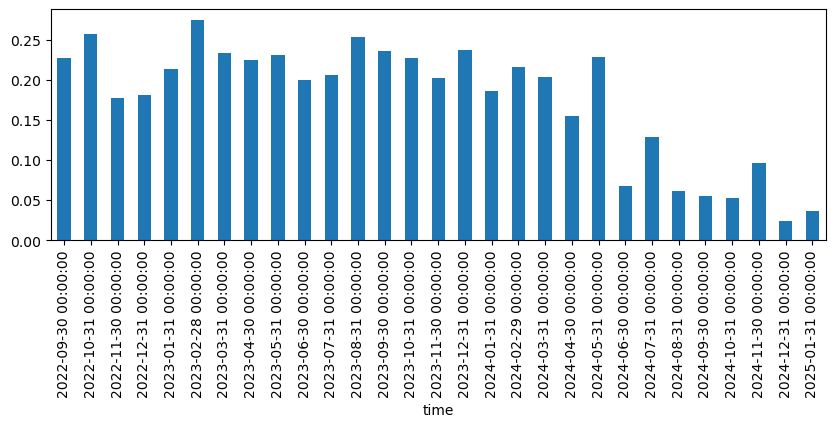

In [6968]:
mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            roc_auc_score(x['target'], x['y_pred'])
                                                                                                          ) - 0.5).plot.bar()

#### 2. WIN

In [6971]:
np.quantile(df.loc[mask_train, 'y_pred'], q=q), np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

(0.5470976913825826, 0.5695387939626755)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/1886071299.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

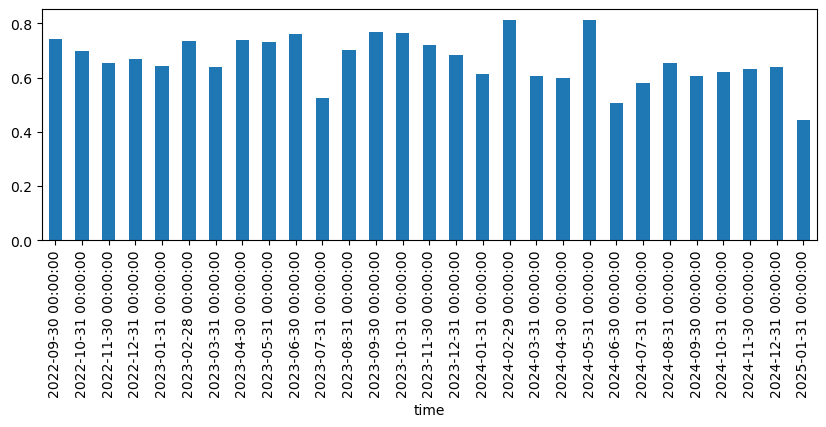

In [6974]:
q = 0.95
col_target = 'target'

mask_last_bin = df['y_pred'] > np.quantile(df.loc[mask_train, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()).plot.bar()

#### 3. income_rate

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/3266133954.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


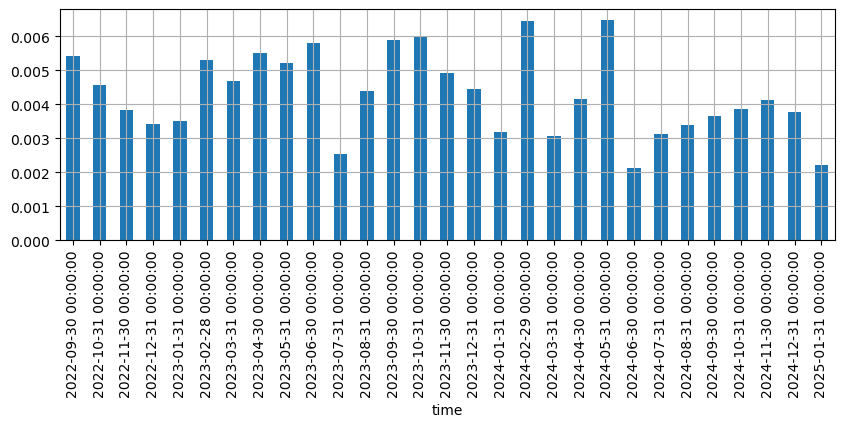

In [6979]:
q = 0.95
col_target = 'income_rate'

mask_last_bin = df['y_pred'] > np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()) -1).plot.bar()
plt.grid()

#### 4. Отложенная выборка

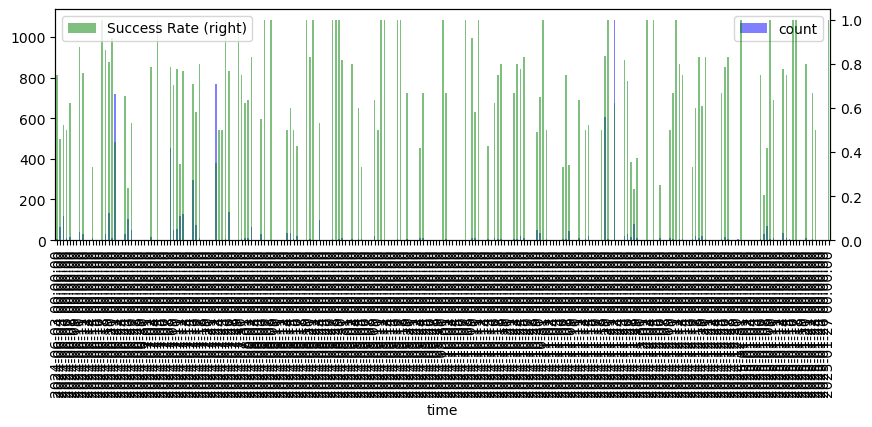

INCOME_RATE


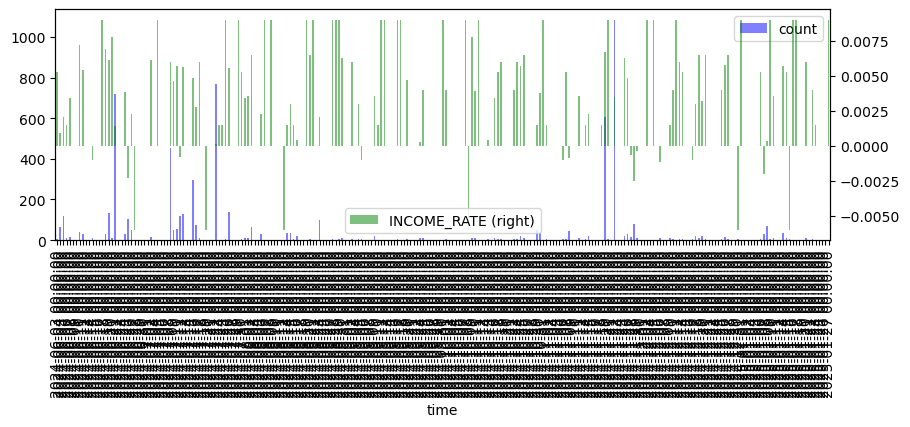

In [6986]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.95
freq='D'

mask_data = mask_valid|mask_test|mask_test2|mask_test3

threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [6989]:
#y_test3

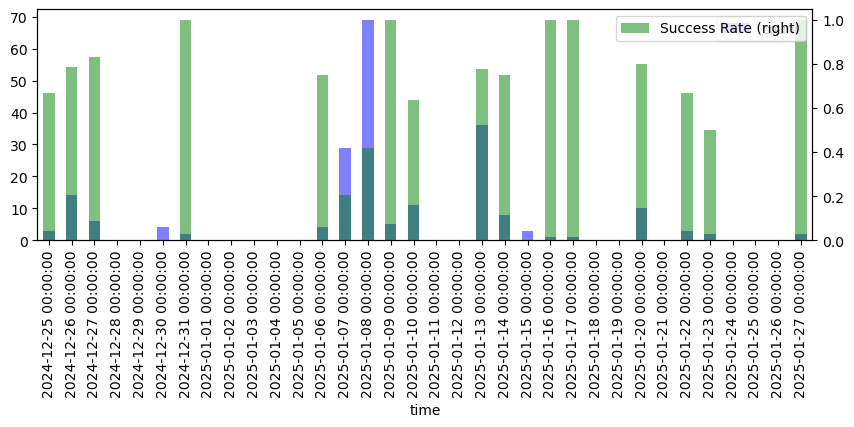

INCOME_RATE


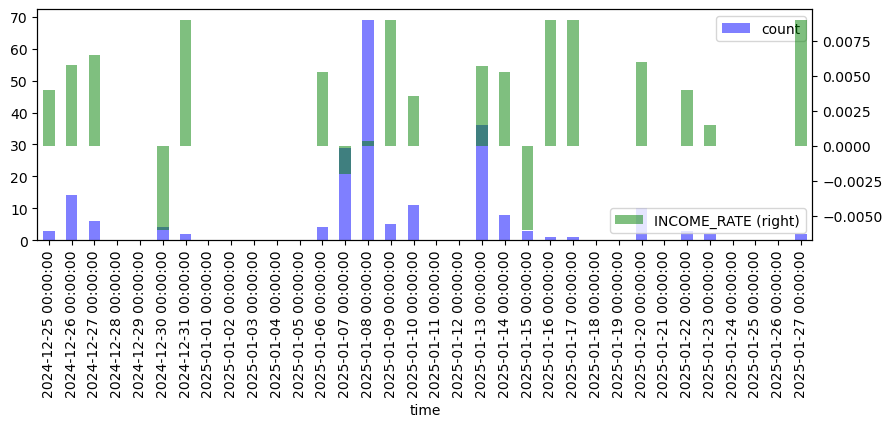

In [6991]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.95
freq='D'


mask_data = mask_test3


threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [6994]:
#mean_income_rate_by_day
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()


(0.00368384503602877, 0.005078761020469622, 0.003918317932451256)

In [6995]:
df.loc[mask_valid&mask_last_bin, 'time'].dt.date.nunique(), df.loc[mask_test&mask_last_bin, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask_last_bin, 'time'].dt.date.nunique()


(36, 31, 46)

In [6998]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.95)

In [7000]:
#sum_income_rate
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06785128531476246, 0.08055151199907634, 0.06720911436679104)

In [7003]:
#test3
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()

0.004147198430895037

In [7005]:
df.loc[mask_test3&mask_last_bin, 'time'].dt.date.nunique()

19

In [7007]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.06934115776456502

In [7011]:
mask_data = mask_valid | mask_test | mask_test2

In [7013]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/1640586492.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.003893196373231804

In [7016]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/1656526771.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.003418934240362887

In [7018]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/192763211.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.005129032258064603

In [7020]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/1559495362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.003431512120046245

In [7022]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/2683039865.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.003473684210526389

#### Points in life

In [7030]:
mask_dev = df['time'] > pd.Timestamp('2025-01-20')
df.loc[mask_dev, 'y_pred'] = model.predict(df.loc[mask_dev, features_fe])

threshold = 0.5695387939626755
df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: (x['y_pred'] >= threshold).sum())

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_86502/3199803634.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(


time
2025-01-20    10
2025-01-21     0
2025-01-22     3
2025-01-23     2
2025-01-24     0
2025-01-25     0
2025-01-26     0
2025-01-27     2
2025-01-28     0
2025-01-29     3
Freq: D, dtype: int64

### Обучить на всем (эксперимент сомнителен)

In [6806]:
mask_data = mask_train | mask_valid | mask_test | mask_test2

D_data = lgbm.Dataset(df.loc[mask_data, features_fe], label=df.loc[mask_data, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_data.income_rate = df.loc[mask_data, 'income_rate'].values

D_data.time = df.loc[mask_data, 'time'].values

In [6813]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [6830]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 # 'metric': 'auc',
 # 'early_stopping': 50
}
THRESHOLD = 0.5695387939626755

model = lgbm.train(params,  num_boost_round=171, train_set=D_data)

In [6831]:
model.num_trees()

171

In [6834]:
y_pred_data= model.predict(D_data.data)


df["y_pred"] = None
df.loc[mask_data, 'y_pred'] = y_pred_data

roc_auc_score(D_data.label, y_pred_data)

0.7161083433530882

In [6836]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5481687811495839

In [6840]:
mean_income_rate_point(D_data, y_pred_data, threshold=THRESHOLD)

0.0051141126297926665

In [6842]:
mean_income_rate_day(D_data, y_pred_data, threshold=THRESHOLD)

0.004175830759625516

In [6844]:
mean_income_rate_month(D_data, y_pred_data, threshold=THRESHOLD)

0.06933454846170668

In [6849]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0002851079406693824

In [6851]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=THRESHOLD)

0.004417058294061401

In [6853]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=THRESHOLD)

0.08551424857302872

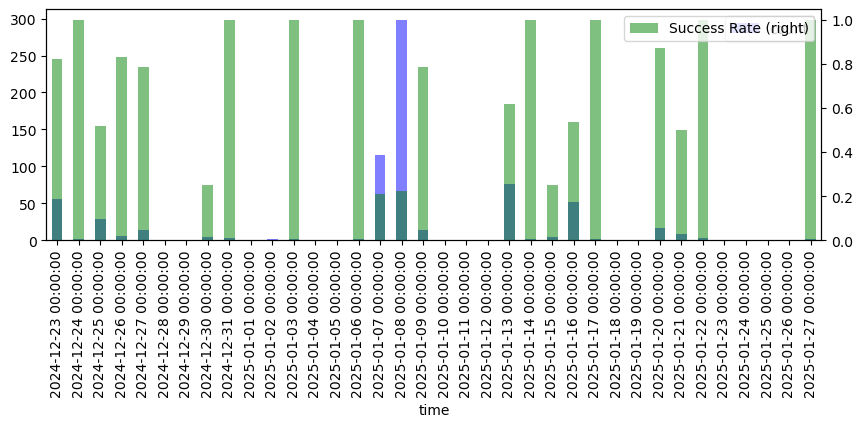

INCOME_RATE


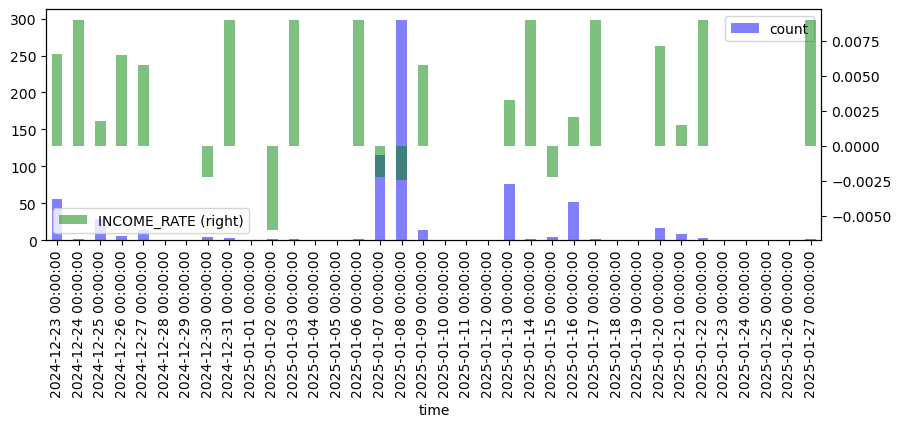

In [6855]:
#distibution in time
#win
col_pred = 'y_pred'
freq='D'


mask_data = mask_test3


#threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > THRESHOLD


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()